In [1]:
import os
from math import pi

os.environ["CUDA_VISIBLE_DEVICES"] = "3"  # Use only the first GPU
from typing import Optional, Tuple, Callable, Union, List
from functools import partial

import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax import vmap, jit
from jax import random
jax.config.update("jax_enable_x64", True)

import numpy as np
from astropy import units as u
from astropy import constants as c

import odisseo
from odisseo import construct_initial_state
from odisseo.integrators import leapfrog
from odisseo.dynamics import direct_acc
from odisseo.option_classes import SimulationConfig, SimulationParams, NFWParams, PlummerParams, NFW_POTENTIAL
from odisseo.initial_condition import Plummer_sphere, ic_two_body
from odisseo.utils import center_of_mass
from odisseo.time_integration import time_integration
from odisseo.units import CodeUnits
from odisseo.visualization import create_3d_gif,create_3d_gif_velocitycoding, create_projection_gif, energy_angular_momentum_plot


plt.rcParams.update({
    'font.size': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 15,
})

# Plummer Sphere

In [2]:
code_length = 10.0 * u.kpc
code_mass = 1e8 * u.Msun
G = 1 
code_units = CodeUnits(code_length, code_mass, G=G)

In [3]:
# Define the 
config = SimulationConfig(N_particles=10_000, 
                          return_snapshots=True, 
                          num_snapshots=100, 
                          num_timesteps=5_000, 
                          external_accelerations=(), 
                          softening=(0.1*u.kpc).to(code_units.code_length).value) #default values

params = SimulationParams(t_end = (1 * u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(1e8 * u.Msun).to(code_units.code_mass).value,
                                                        a=(1 * u.kpc).to(code_units.code_length).value),
                          G=G, ) 

print(config)
print(params)

SimulationConfig(N_particles=10000, dimensions=3, return_snapshots=True, num_snapshots=100, fixed_timestep=True, num_timesteps=5000, softening=0.010000000000000002, integrator=0, acceleration_scheme=0, batch_size=10000, double_map=False, external_accelerations=())
SimulationParams(G=1, t_end=0.6707087409203456, Plummer_params=PlummerParams(a=0.1, Mtot=1.0), NFW_params=NFWParams(Mvir=162000000000.0, r_s=15.3, c=10, d_c=1.4888043637074615), PointMass_params=PointMassParams(M=1.0), MN_params=MNParams(M=65000000000.0, a=3.0, b=0.28))


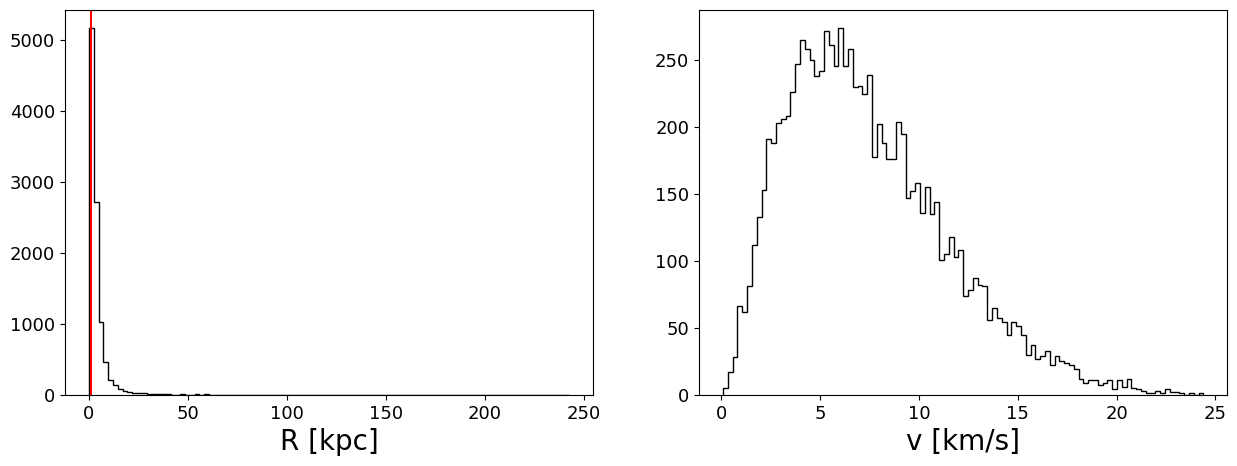

In [4]:
#set up the particles in the initial state
positions, velocities, mass = Plummer_sphere(key=random.PRNGKey(0), params=params, config=config)

#Plummer sphere distribution
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(121)
ax.hist((jnp.linalg.norm(positions, axis=1) * code_units.code_length).to(u.kpc), bins=100, histtype='step', color='k')
ax.axvline((params.Plummer_params.a*code_units.code_length).to(u.kpc).value, color='r', label='Plummer a')
ax.set_xlabel('R [kpc]')

ax = fig.add_subplot(122)
ax.hist(jnp.linalg.norm((velocities * code_units.code_velocity).to(u.km/u.s).value, axis=1), bins=100, histtype='step', color='k')
ax.set_xlabel('v [km/s]')
plt.show()


#initialize the initial state
initial_state = construct_initial_state(positions, velocities)

In [5]:
if config.return_snapshots: 
    snapshots = jax.block_until_ready(time_integration(initial_state, mass, config, params))
else:
    final_state = jax.block_until_ready(time_integration(initial_state, mass, config, params))


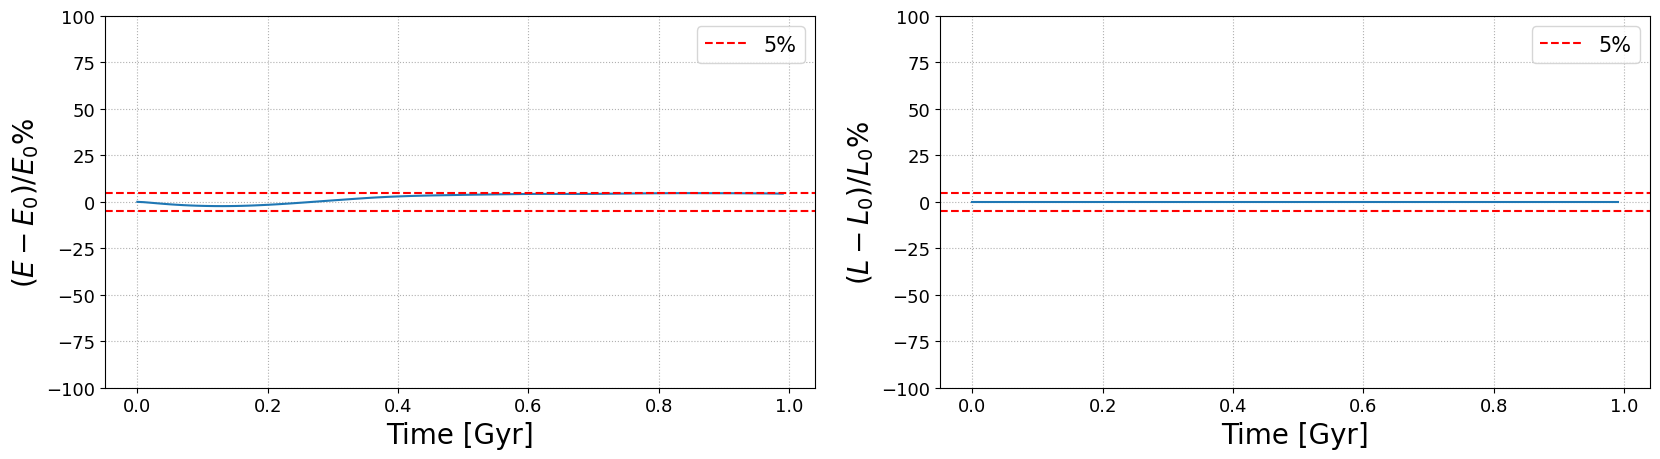

In [6]:
energy_angular_momentum_plot(snapshots, code_units, filename='./visualization/image/E_L_Plummer.pdf')

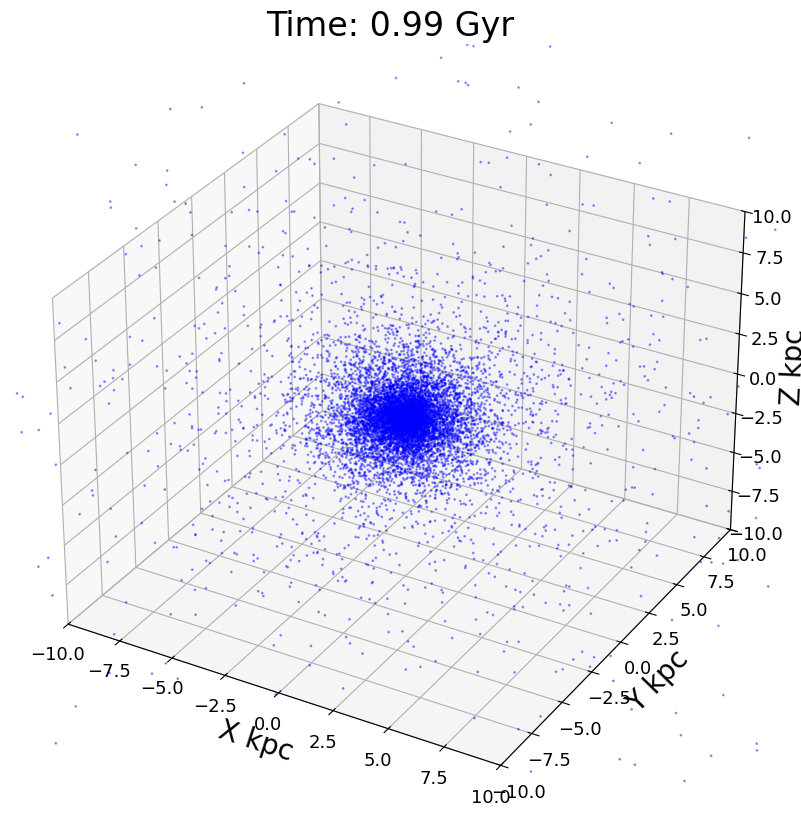

In [7]:
create_3d_gif(snapshots, 
              ax_lim=(10*params.Plummer_params.a*code_units.code_length).value, 
              code_units=code_units, 
              plotting_units_length=u.kpc, 
              plot_units_time=u.Gyr, 
              filename='./visualization/gif/simulation_Plummer.gif')

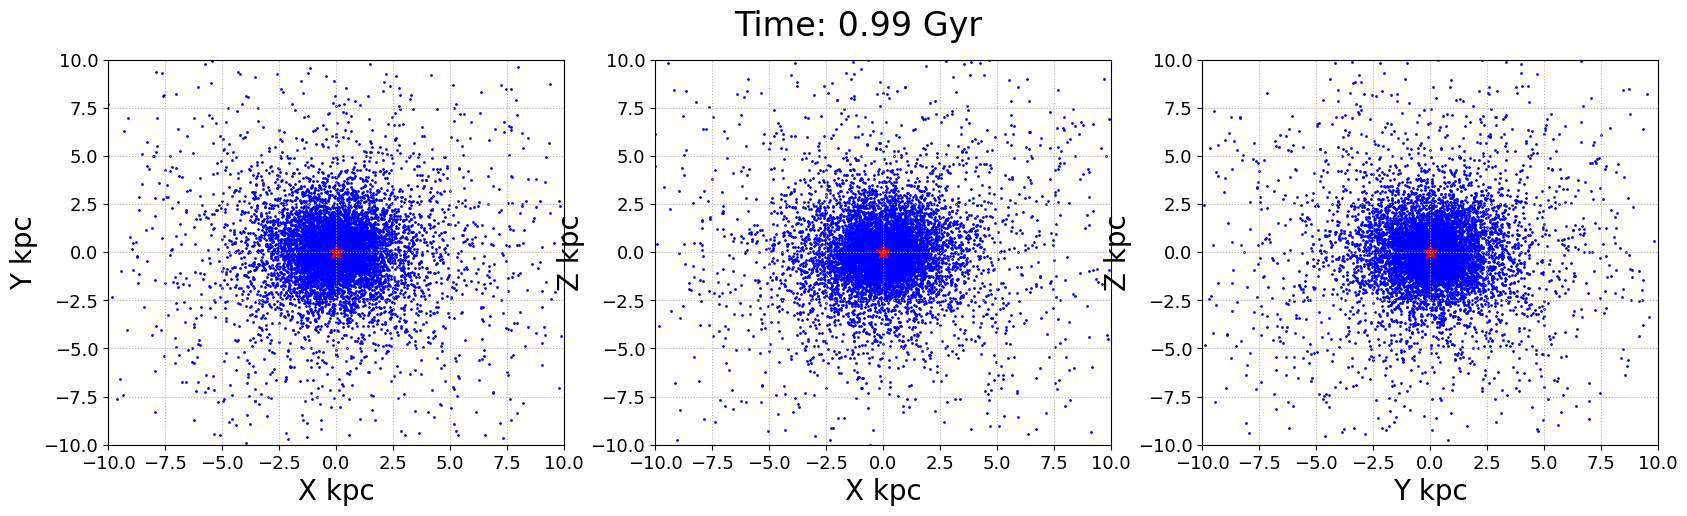

In [8]:
create_projection_gif(snapshots=snapshots,
                      ax_lim=(10*params.Plummer_params.a*code_units.code_length).value,  
                      code_units=code_units, 
                      plotting_units_length=u.kpc, 
                      plot_units_time=u.Gyr, 
                      filename='./visualization/gif/simulation_projection_Plummer.gif')